In [36]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import os

import warnings
warnings.filterwarnings("ignore")

Задаем параметры, необходимые для подготовки dataset'a

In [37]:
path_tickers = '/Users/ilia/PycharmProjects/real-AI-Trading/data/Разметка_Y'
path_outputs = '/Users/ilia/PycharmProjects/real-AI-Trading/data/outputs'
path_models = '/Users/ilia/PycharmProjects/real-AI-Trading/data/models'
#path_tickers = '/content/drive/MyDrive/_Проекты/AI_Trading/AI-trading_courses/Y'
#path_outputs = '/content/drive/MyDrive/_Проекты/AI_Trading/AI-trading_courses/outputs'
#path_models = '/content/drive/MyDrive/_Проекты/AI_Trading/AI-trading_courses/models'

os.chdir(path_tickers)
tickers_list = os.listdir()
print('Всего тикеров: ', len(tickers_list), '\n')
tickers_list

Всего тикеров:  5 



['Adam_SBER_MIN60.csv',
 '.DS_Store',
 'Super-Dooper_SBER_MIN60.csv',
 'Super-Dooper_SBER_MIN60_nn.csv',
 'Extremum_SBER_MIN60.csv']

In [38]:
ensemble = 40             # Серию из скольки баров назад анализируем  #40, 60
forvard_lag = 1            # Предсказание какого бара в будущем делаем
test_lvl = .2              # Обьем выборки, уходящей в xTest
analyze_period = 30000     # Сколько баров в прошлое берем для тренировки модели (чтобы ихбежать тренировки на другой динамике рынка) #3000,2000,1000

40,  14 и только ohe

# Подготовка данных

### Загрузка и первичная обработка данных

In [39]:
ticker = 'Super-Dooper_SBER_MIN60_nn.csv'
ticker

'Super-Dooper_SBER_MIN60_nn.csv'

In [40]:
os.chdir(path_tickers)
# Загрузка только [Open, High, Low, Close]
df = pd.read_csv(ticker, sep=";", header=0)#, index_col=0)

del df['Time'], df['Date']
#df.columns=['datetime', 'open', 'high', 'low', 'close', 'order']
df

,datetime,Open,High,Low,Close,Order,Order_NN
0,2000-01-05 11:00:00,1.15000,1.17000,1.0800,1.125,0,0
1,2000-01-05 12:00:00,1.13500,1.17300,1.1350,1.168,0,0
2,2000-01-05 13:00:00,1.16500,1.23999,1.1650,1.200,0,0
3,2000-01-05 14:00:00,1.20000,1.25500,1.1980,1.255,0,0
4,2000-01-05 15:00:00,1.23001,1.26488,1.2115,1.264,0,0
...,...,...,...,...,...,...,...
43128,2019-12-30 14:00:00,253.05000,255.25000,252.9700,255.210,0,1
43129,2019-12-30 15:00:00,255.20000,256.00000,254.8600,255.160,0,1
43130,2019-12-30 16:00:00,255.16000,255.94000,254.5300,255.620,-1,-1
43131,2019-12-30 17:00:00,255.62000,255.65000,254.5500,254.810,0,-1


In [41]:
# Период на котором будем учить нейронку
mask = (df['datetime'] >= '2018-01-01 10:00:00') & (df['datetime'] <= '2018-12-31 23:59:00')
data = df[mask]
#del data['Order'], data['Order_NN']
data

,datetime,Open,High,Low,Close,Order,Order_NN
38589,2018-01-03 10:00:00,226.88,230.00,226.35,228.52,0,1
38590,2018-01-03 11:00:00,228.45,230.58,228.41,229.66,0,1
38591,2018-01-03 12:00:00,229.65,230.00,229.00,229.90,0,1
38592,2018-01-03 13:00:00,229.90,230.80,229.60,230.38,0,1
38593,2018-01-03 14:00:00,230.42,231.87,230.39,231.27,0,1
...,...,...,...,...,...,...,...
40860,2018-12-29 14:00:00,186.07,186.08,185.78,185.88,0,-1
40861,2018-12-29 15:00:00,185.88,185.95,185.70,185.70,1,1
40862,2018-12-29 16:00:00,185.70,186.15,185.70,186.15,0,1
40863,2018-12-29 17:00:00,186.15,186.35,186.00,186.02,0,1


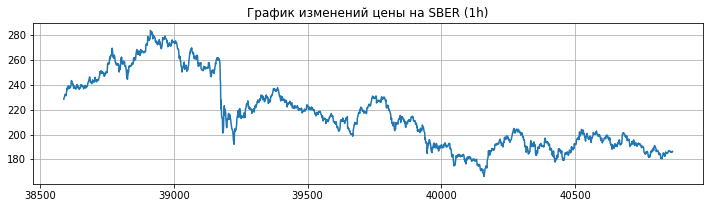

In [42]:
plt.figure(figsize=(12,4))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
data['Close'].plot(ax = ax0)
plt.title('График изменений цены на SBER (1h)')
plt.grid()

### Фич инжиниринг

In [43]:
# тут я удаляю "не нужные" данные и переимновываю под привычные мне
# и под стандарт, в котором выдает данные сервис yahoo (на всякий случай)
df_date = data['datetime'] # Оставляем дату, чтобы потом добавить в outputs
del data['datetime']
df_date[:3]

38589    2018-01-03 10:00:00
38590    2018-01-03 11:00:00
38591    2018-01-03 12:00:00
Name: datetime, dtype: object

In [44]:
# найдем изменение цены по отношению к прошлой на step_in_the_last шагов назад
"""
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  data[indicator_name] = data['Close'].pct_change(i) # относительная доходность единицах

data = data.dropna() # удаляем строки с NaN
print(data.shape)
data[-3:]"""

"\nfor i in range(1, step_in_the_last + 1):\n  indicator_name = 'Close_chng_%d' % (i)\n  data[indicator_name] = data['Close'].pct_change(i) # относительная доходность единицах\n\ndata = data.dropna() # удаляем строки с NaN\nprint(data.shape)\ndata[-3:]"

In [45]:
# Добавил разметку как в Y но сдвинул на тренд
"""
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  indicator_name_new = 'Y_%d' % (i)
  data[indicator_name_new] = 0
  data.loc[data[indicator_name] < 0, indicator_name_new] = -1
  data.loc[data[indicator_name] > 0, indicator_name_new] = 1

print(data.shape)
data[-3:]"""

"\nfor i in range(1, step_in_the_last + 1):\n  indicator_name = 'Close_chng_%d' % (i)\n  indicator_name_new = 'Y_%d' % (i)\n  data[indicator_name_new] = 0\n  data.loc[data[indicator_name] < 0, indicator_name_new] = -1\n  data.loc[data[indicator_name] > 0, indicator_name_new] = 1\n\nprint(data.shape)\ndata[-3:]"

In [46]:
# --------------------------------
Y_Order_NN = data['Order_NN']
Y_Order = data['Order']
# --------------------------------
#del data['Order_NN'], data['Order']

"""# эксперимент - оставлю только ohe
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  del data[indicator_name]"""

"""# эксперимент - оставлю только ohe
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Y_%d' % (i)
  del data[indicator_name]"""

#del data['Open'], data['High'], data['Low']
print(data.shape)
data[-3:]

(2276, 6)


,Open,High,Low,Close,Order,Order_NN
40862,185.70,186.15,185.70,186.15,0,1
40863,186.15,186.35,186.00,186.02,0,1
40864,186.05,186.49,185.97,186.34,0,1


### Перевод Y в ohe

In [47]:
# превожу в to_categorical
from keras.utils import to_categorical
#categorical_labels = to_categorical(Y_Order, num_classes = 3)
categorical_labels = to_categorical(Y_Order_NN, num_classes = 3)
print(len(categorical_labels))
categorical_labels[-10:]

2276


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

## Делим на обучающую, тестовую и валидационную выборки

### Деление на выборки train, test

In [48]:
data = data.values
print(data.shape, type(data))

(2276, 6) <class 'numpy.ndarray'>


In [49]:
# берем для xTest последние 20% значений, но кратно n_steps
n_train = int(len(data)*test_lvl//ensemble * ensemble) #  то, что уходит в train 
xTrain = data[:-n_train]
xTest = data[-n_train:]
yTrain = categorical_labels[:-n_train]
yTest = categorical_labels[-n_train:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)
xTrain.shape[0]+xTest.shape[0]

xTrain:  (1836, 6) 	yTrain: (1836, 3) 
xTest:   (440, 6) 	yTest:  (440, 3)


2276

In [50]:
data[-n_train:][-3:] # последняя подаваемая строка

array([[185.7 , 186.15, 185.7 , 186.15,   0.  ,   1.  ],
       [186.15, 186.35, 186.  , 186.02,   0.  ,   1.  ],
       [186.05, 186.49, 185.97, 186.34,   0.  ,   1.  ]])

In [51]:
yTest[-n_train:][-3:] # последняя подаваемая строка

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

### Скалирование Х

In [52]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все
""" 
# Масштабируем только X
"""
#xScaler = StandardScaler()
xScaler = RobustScaler()
#xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

(1836, 6) (440, 6) <class 'numpy.ndarray'>


array([[-0.76488213, -0.76515913, -0.73031026, -0.75656486,  0.        ,
         1.        ]])

In [53]:
# проверяю обратную трансформацию
x = xScaler.inverse_transform(xTest[-1:])
x[-1][3]

186.34

### Превращение в TimeSeries

In [54]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# ensenmble = число баров в прошлом для анализа - необходимо найти оптимальный!!
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence(sequence, Y, ensemble, forvard_lag):
  # sequence = df.values - это массив из данных
  # n_steps = число баров в прошлом для анализа
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + ensemble # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) # тк предсказываем только Close
  return array(X), array(y)

In [55]:
"""
# Число баров в прошлом для анализа - место для эксперимента от 0 до 90
"""
# Формируем выборки для обучения нейросети
xTrain, yTrain = split_sequence(xTrain, yTrain, ensemble, forvard_lag)

print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
print('Массивы xTrain и yTrain:\t', xTrain.shape, yTrain.shape)

#y[97:102], X[97:102]  # чтобы проверить наличие сдвига


Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTrain и yTrain:	 (1796, 40, 6) (1796, 3)


In [56]:
"""
# Число баров в прошлом для анализа - место для эксперимента от 0 до 90
"""
# Формируем выборки для обучения нейросети
xTest, yTest = split_sequence(xTest, yTest, ensemble, forvard_lag)

print('\nОбратите внимание на потерянные ensemble данных в начале выборки:')
print('Массивы xTest и yTest:\t', xTest.shape, yTest.shape)

#y[97:102], X[97:102]  # чтобы проверить наличие сдвига


Обратите внимание на потерянные ensemble данных в начале выборки:
Массивы xTest и yTest:	 (400, 40, 6) (400, 3)


In [57]:
close = xScaler.inverse_transform(xTest[-1])
close[-1][3], yTest[-1] #сдвинули Y на 1 назад и поэтому исчез последний X

(186.02, array([0., 1., 0.], dtype=float32))

In [58]:
close = xScaler.inverse_transform(xTest[-2])
close[-1][3], yTest[-2]

(186.15, array([0., 1., 0.], dtype=float32))

# Нейросети

In [59]:
import tensorflow
tensorflow.__version__

'2.0.0'

In [60]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, 
                                     GRU, LSTM, Bidirectional, Conv1D, SeparableConv1D, MaxPooling1D,
                                     Reshape, RepeatVector, SpatialDropout1D, LeakyReLU)
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from keras.utils import plot_model
from IPython.display import clear_output

### Conv1D_v1

In [61]:
# -----------------------------
# Conv1D = создаем модель
# -----------------------------
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке

input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
x = Flatten()(input)
x = RepeatVector(8)(x)
x = Conv1D(512, 8, padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv1D(32, 3, padding = 'same')(x)
x = LeakyReLU()(x)
x = GRU(256)(x)
x = Dense(2048)(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)
x = Dense(yTrain.shape[1], activation = 'softmax')(x)

model = Model(input, x)
#print(model.summary()) #Вывод структуры модели
#plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

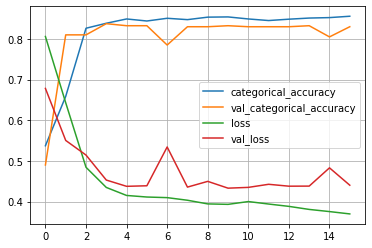

In [62]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 5e-05),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

os.chdir(path_models)
# коллбэки
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 0)
checkpoint = ModelCheckpoint('_SBER_Conv_1h.h5', monitor='val_categorical_accuracy', verbose = 0,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 1,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [63]:
os.chdir(path_models)
model = load_model('_SBER_Conv_1h.h5')

# От себя добавил цикл для распознавания всех тестовых вариантов и вывода класса
x_test = xTest[-200:]
y_test_org = yTest[-200:]
conv_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    conv_test.append('True')
  else:
    conv_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])

clear_output()
from collections import Counter
accuracyConv = Counter(conv_test)
print(accuracyConv)

Counter({'True': 173, 'False': 27})


### Conv1D_v2

In [64]:
# -----------------------------
# Conv1D_2 = создаем модель
# -----------------------------
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
drop = 0.4

input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(ensemble*2, 5, padding='same')(x) #relu, selu, softplus !!
x = LeakyReLU(alpha=0.1)(x) # Default to 0.3
x = MaxPooling1D(pool_size=2)(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(ensemble, 5, padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling1D(pool_size=2)(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)
x = Dense(ensemble*100)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(drop)(x)
x = Dense(yTrain.shape[1], activation='softmax')(x)

model = Model(input, x)

#print(model.summary()) #Вывод структуры модели
#plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

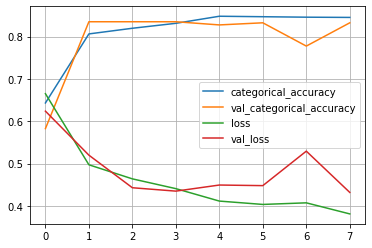

In [65]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 1e-03),#5e-05),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

os.chdir(path_models)
# коллбэки
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 6, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 0)
checkpoint = ModelCheckpoint('_SBER_Conv_2_1h.h5', monitor='val_categorical_accuracy', verbose = 0,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 1,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [66]:
os.chdir(path_models)
model = load_model('_SBER_Conv_2_1h.h5')

# От себя добавил цикл для распознавания всех тестовых вариантов и вывода класса
x_test = xTest[-200:]
y_test_org = yTest[-200:]
conv_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    conv_test.append('True')
  else:
    conv_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])

clear_output()
from collections import Counter
accuracyConv = Counter(conv_test)
print(accuracyConv)

Counter({'True': 172, 'False': 28})


### Dense_v1

In [67]:
drop = 0.4
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = Flatten()(input)
x = Dense(ensemble*500, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(ensemble*100, activation='relu')(x)
x = Dropout(drop)(x)

#x = RepeatVector(2)(x)
#x = LSTM(120, dropout=drop)(x)
#x = Dense(n_steps, activation='relu')(x)

x = Dense(yTrain.shape[1], activation='softmax')(x)
model = Model(input, x)

#print(model.summary())

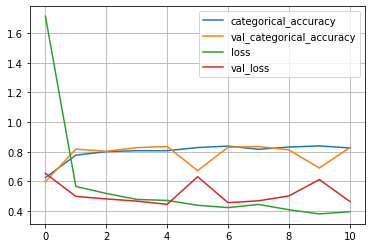

In [68]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 1e-03),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 6, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_Dense_1h.h5', monitor='val_categorical_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 1,
                    validation_data = (xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [69]:
os.chdir(path_models)
model = load_model('_SBER_Dense_1h.h5')

n = 200 # сколько данных с конца берем для проверки
# От себя добавил цикл для распознавания всех тестовых вариантов и вывода класса
x_test = xTest[-n:]
y_test_org = yTest[-n:]
dense_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    dense_test.append('True')
  else:
    dense_test.append('False')

  print('Index:', i, '\tPrediction:', '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])


clear_output()
from collections import Counter
accuracyDense = Counter(dense_test)
print(accuracyDense)

Counter({'True': 174, 'False': 26})


### Dense_v2

In [70]:
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = Flatten()(input)
x = Dense(ensemble*100)(x)
x = LeakyReLU(alpha=0.1)(x) # Default to 0.3
x = Dropout(drop)(x)

x = Dense(yTrain.shape[1], activation='sigmoid')(x)
model = Model(input, x)

#print(model.summary())

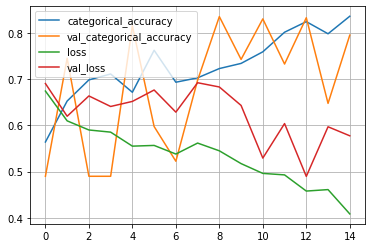

In [71]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 1e-03),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 8, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_Dense_1h_v2.h5', monitor='val_categorical_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 1,
                    validation_data = (xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [72]:
os.chdir(path_models)
model = load_model('_SBER_Dense_1h_v2.h5')

n = 200 # сколько данных с конца берем для проверки
# От себя добавил цикл для распознавания всех тестовых вариантов и вывода класса
x_test = xTest[-n:]
y_test_org = yTest[-n:]
dense_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    dense_test.append('True')
  else:
    dense_test.append('False')

  print('Index:', i, '\tPrediction:', '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])


clear_output()
from collections import Counter
accuracyDense = Counter(dense_test)
print(accuracyDense)

Counter({'True': 172, 'False': 28})


### LSTM_v1



In [73]:
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = LSTM(ensemble*9, dropout=drop)(input)

x = RepeatVector(9)(x)
x = LSTM(ensemble*9, dropout=drop)(x)

x = Dense(ensemble*10, activation='relu')(x)
x = Dropout(drop)(x)

x = Dense(yTrain.shape[1], activation='softmax')(x)
model = Model(input, x)

#print(model.summary())

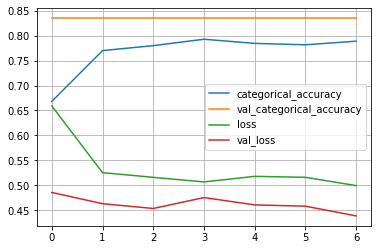

In [74]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 1e-03),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 6, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_LSTM_1h.h5', monitor='val_categorical_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose=1,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [75]:
os.chdir(path_models)
model = load_model('_SBER_LSTM_1h.h5')

x_test = xTest[-200:]
y_test_org = yTest[-200:]
lstm_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    lstm_test.append('True')
  else:
    lstm_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])


clear_output()
from collections import Counter
accuracyLSTM = Counter(lstm_test)
print(accuracyLSTM)

Counter({'True': 172, 'False': 28})


### LSTM_v2

In [77]:
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
x = LSTM(ensemble*9, dropout=drop)(input)

x = RepeatVector(3)(x)
x = LSTM(ensemble*9, dropout=drop)(x)

x = Dense(ensemble*10)(x)
x = LeakyReLU(alpha=0.1)(x) # Default to 0.3
x = Dropout(drop)(x)

x = Dense(yTrain.shape[1], activation='softmax')(x)
model = Model(input, x)

#print(model.summary())

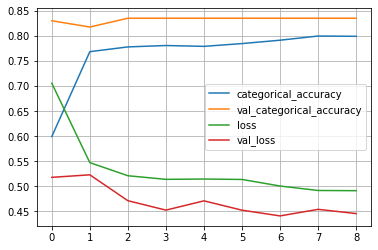

In [78]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 1e-03),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 6, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_LSTM_1h_v2.h5', monitor='val_categorical_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose=1,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [79]:
os.chdir(path_models)
model = load_model('_SBER_LSTM_1h_v2.h5')

x_test = xTest[-200:]
y_test_org = yTest[-200:]
lstm_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    lstm_test.append('True')
  else:
    lstm_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])


clear_output()
from collections import Counter
accuracyLSTM = Counter(lstm_test)
print(accuracyLSTM)

Counter({'True': 172, 'False': 28})


## Concatenate

In [86]:
""" обьединим все сети """

drop = 0.4

## входной слой
input_layer = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке

# -----------------------------
# Conv1D v1 = создаем модель
# -----------------------------
_conv1 = Flatten()(input_layer)
_conv1 = RepeatVector(8)(_conv1)
_conv1 = Conv1D(512, 8, padding = 'same')(_conv1)
_conv1 = LeakyReLU()(_conv1)
_conv1 = Conv1D(32, 3, padding = 'same')(_conv1)
_conv1 = LeakyReLU()(_conv1)
_conv1 = GRU(256)(_conv1)
_conv1 = Dense(2048)(_conv1)
_conv1 = LeakyReLU()(_conv1)
_conv1 = Dropout(0.5)(_conv1)
_conv1 = Dense(yTrain.shape[1], activation = 'softmax')(_conv1)

# -----------------------------
# Conv1D v2 = создаем модель
# -----------------------------
_conv2 = Flatten()(input_layer)
_conv2 = RepeatVector(4)(_conv2)
_conv2 = Conv1D(ensemble*2, 5, padding='same')(_conv2) #relu, selu, softplus !!
_conv2 = LeakyReLU(alpha=0.1)(_conv2) # Default to 0.3
_conv2 = MaxPooling1D(pool_size=2)(_conv2)
_conv2 = LeakyReLU(alpha=0.1)(_conv2)

_conv2 = Flatten()(_conv2)
_conv2 = RepeatVector(4)(_conv2)
_conv2 = Conv1D(ensemble, 5, padding='same')(_conv2)
_conv2 = LeakyReLU(alpha=0.1)(_conv2)
_conv2 = MaxPooling1D(pool_size=2)(_conv2)
_conv2 = LeakyReLU(alpha=0.1)(_conv2)

_conv2 = Flatten()(_conv2)
_conv2 = Dense(ensemble*100)(_conv2)
_conv2 = LeakyReLU(alpha=0.1)(_conv2)
_conv2 = Dropout(drop)(_conv2)
_conv2 = Dense(yTrain.shape[1], activation='softmax')(_conv2)

# -----------------------------
# Dense_v1 = создаем модель
# -----------------------------
_dense = Flatten()(input_layer)
_dense = Dense(ensemble*500, activation='relu')(_dense)
_dense = Dropout(drop)(_dense)
_dense = Dense(ensemble*100, activation='relu')(_dense)
_dense = Dropout(drop)(_dense)
_dense  = Dense(yTrain.shape[1], activation='softmax')(_dense)

# -----------------------------
# Dense_v2 = создаем модель
# -----------------------------
_dense2 = Flatten()(input_layer)
_dense2 = Dense(ensemble*100)(_dense2)
_dense2 = LeakyReLU(alpha=0.1)(_dense2) # Default to 0.3
_dense2 = Dropout(drop)(_dense2)
_dense2 = Dense(yTrain.shape[1], activation='softmax')(_dense2)

# -----------------------------
# LSTM_v1 = создаем модель
# -----------------------------
_lstm = LSTM(ensemble*9, dropout=drop)(input_layer)
_lstm = RepeatVector(9)(_lstm)
_lstm = LSTM(ensemble*9, dropout=drop)(_lstm)
_lstm = Dense(ensemble*10, activation='relu')(_lstm)
_lstm = Dropout(drop)(_lstm)
_lstm = Dense(yTrain.shape[1], activation='softmax')(_lstm)

# -----------------------------
# LSTM_v2 = создаем модель
# -----------------------------
_lstm2 = LSTM(ensemble*9, dropout=drop)(input_layer)
_lstm2 = RepeatVector(3)(_lstm2)
_lstm2 = LSTM(ensemble*9, dropout=drop)(_lstm2)
_lstm2 = Dense(ensemble*10)(_lstm2)
_lstm2 = LeakyReLU(alpha=0.1)(_lstm2) # Default to 0.3
_lstm2 = Dropout(drop)(_lstm2)
_lstm2 = Dense(yTrain.shape[1], activation='softmax')(_lstm2)


# CONCATENATEs
conc_1 = concatenate([_conv1, _conv2, _dense, _dense2, _lstm, _lstm2, Flatten()(input_layer)])
conc_2 = Flatten()(conc_1)
conc_3 = Dense(500, activation='relu')(conc_2)
conc_4 = Dropout(drop)(conc_3)
output_layer = Dense(yTrain.shape[1], activation='softmax')(conc_4)


modelMerge = Model(inputs=input_layer, outputs=output_layer)

In [87]:
#plot_model(modelMerge, show_shapes=True, dpi=50)

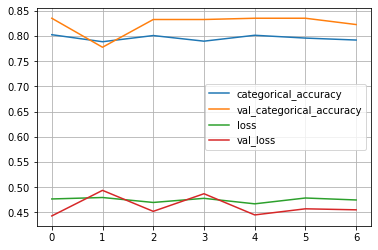

In [88]:

modelMerge.compile(optimizer=Adam(learning_rate = 1e-03),#1e-05),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']) 

os.chdir(path_models)

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 6, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_CONC_1h.h5', monitor='val_categorical_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose=1,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [89]:
os.chdir(path_models)
model = load_model('_SBER_CONC_1h.h5')

x_test = xTest[-200:]
y_test_org = yTest[-200:]
lstm_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    lstm_test.append('True')
  else:
    lstm_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])


clear_output()
from collections import Counter
accuracyLSTM = Counter(lstm_test)
print(accuracyLSTM)

Counter({'True': 172, 'False': 28})


# Моделирование торговли

In [90]:
from IPython.display import clear_output
from tensorflow.keras.models import load_model

In [91]:
os.chdir(path_models)
models_list = os.listdir()
print('Всего моделей: ', len(models_list), '\n')
models_list

Всего моделей:  7 



['_SBER_Conv_1h.h5',
 '_SBER_Dense_1h_v2.h5',
 '_SBER_Dense_1h.h5',
 '_SBER_LSTM_1h_v2.h5',
 '_SBER_Conv_2_1h.h5',
 '_SBER_LSTM_1h.h5',
 '_SBER_CONC_1h.h5']

### Функции моделирования торговли и отрисовки графиков

In [92]:
def trading(model, xTest):
  x_test = xTest
  returns = pd.DataFrame()
  statement = 0 #  {0:in_cash, 1:long, 2:short}
  stock = 0.   # Число акций
  cash = 1000000.   # Стартовая сумма капитала
  # -----------------------------------------

  for i in range(len(x_test)):   # Выбираю пример
    x = x_test[i]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x) # Распознаём наш пример  == {0:stay, 1:up, 2:down}
    signal = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)
    close = xScaler.inverse_transform(x_test[i])
    close = close[-1][3]

    if statement == 0  and  signal == 1:##
      statement = 1
      capital = cash//close * close + cash - cash//close * close
      inv_capital = cash//close * close
      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[cash//close], 'deal_prise':[close],
                           'long':[close*0.9], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash - cash//close * close],
                           'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue

    elif statement == 0  and  signal == 2: ##
      statement = 2
      stock = -(cash//close)
      inv_capital = -close*stock
      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[0], 'short':[close*1.1], 'inv_capital':[inv_capital],  'cash':[cash - inv_capital],
                           'capital':[cash], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
      
    elif statement == 0  and  signal == 0:##
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'stock':[0],  'deal_prise':[0],
                           'long':[0], 'short':[0], 'inv_capital':[0], 'cash':[cash], 'capital':[cash], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
      
    elif statement == 2  and  signal == 1: ##
      statement = 1
      ret = (close-returns.iloc[i-1][4])*stock
      capital = -stock*returns.iloc[i-1][4] + returns.iloc[i-1][8] + ret
      stock = capital//close
      inv_capital = close*stock
      cash = capital - inv_capital
      line = pd.DataFrame({'statement':[2], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[close*0.9], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue

    elif statement == 2  and  signal == 2: ##
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = -stock*returns.iloc[i-1][4] + (close - returns.iloc[i-1][4])*stock
      capital = inv_capital + cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
      
    elif statement == 2  and  signal == 0: ##
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = -stock*returns.iloc[i-1][4] + (close - returns.iloc[i-1][4])*stock
      capital = inv_capital + cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
      
    elif statement == 1  and  signal == 1:##
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = close*stock
      capital = close*stock+cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash],  'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue

    elif statement == 1  and  signal == 2:##
      statement = 2
      stock = returns.iloc[i-1][3]
      ret = (close - returns.iloc[i-1][4]) * stock
      capital = close * stock + returns.iloc[i-1][8]
      stock = -capital//close
      inv_capital = -close*stock
      cash = capital - inv_capital
      line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[0], 'short':[close*1.1], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
      
    elif statement == 1  and  signal == 0:##
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = close*stock
      capital = close*stock+cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue


  #clear_output()
  #returns = returns.append(line, ignore_index=True)
  #print(returns.shape)
  #print(returns)
  return returns


In [93]:
xTrain.shape, xScaler.inverse_transform(xTrain[-1])[-1:] # проверка последней подаваемой строки

((1796, 40, 6), array([[182.34, 182.35, 180.03, 180.7 ,   0.  ,  -1.  ]]))

In [94]:
def plotting(returns):
  short = returns['short'].values
  short = short.astype(bool)
  long = returns['long'].values
  long = long.astype(bool)
  idx_long = np.where(long) 
  idx_short = np.where(short) 

  plt.figure(figsize=(18,4))

  plt.subplot(121)
  plt.plot(returns['close'], alpha=0.6)
  plt.plot(idx_long, returns['close'].values[[idx_long]], '^', c='g')
  plt.plot(idx_short, returns['close'].values[[idx_short]], 'v', c='r')
  plt.grid()

  plt.subplot(122)
  plt.plot(returns['capital'])
  plt.grid()
  plt.show()

In [95]:
## Применим функцию Long
def trading_long(model, xTest, commission=0):
    """
    :param xTest: цена Close
    :param yTest: торговый сигнал signal
    :return:
    """
    x_test = xTest
    returns = pd.DataFrame()
    statement = 0 #  {0:in_cash, 1:long, 2:short}
    stock = 0.   # Число акций
    cash = 1000000.   # Стартовая сумма капитала
    fees_sum = 0
    # -----------------------------------------

    for i in range(len(x_test)):   # Выбираю пример
        x = x_test[i]
        x = np.expand_dims(x, axis=0)
        prediction = model.predict(x) # Распознаём наш пример  == {0:stay, 1:up, 2:down}
        signal = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)
        close = xScaler.inverse_transform(x_test[i])
        close = close[-1][3]

        #print(i, '\tstatement =', statement, '\tsignal =', signal)

        if statement == 0 and signal == 1:  # становимся в long
            statement = 1
            inv_capital = (cash // close * close) * (1 - commission)
            fees = (cash // close * close) * commission
            fees_sum += fees
            capital = cash - fees
            line = pd.DataFrame({'statement': [0], 'signal': [signal], 'close': [close], 'stock': [cash // close],
                                 'deal_prise': [close],
                                 'long': [close * 0.9], 'short': [0], 'inv_capital': [inv_capital],
                                 'cash': [cash - cash // close * close], 'capital': [capital],
                                 'ret(i)': [0], 'fees':[fees], 'fees_sum': [fees_sum]})
            returns = returns.append(line, ignore_index=True)
            continue


        elif statement == 0 and signal == 2:  # ничего не делаем
            line = pd.DataFrame(
                {'statement': [statement], 'signal': [signal], 'close': [close], 'stock': [0], 'deal_prise': [0],
                 'long': [0], 'short': [0], 'inv_capital': [0], 'cash': [cash],
                 'capital': [cash], 'ret(i)': [0], 'fees':[0], 'fees_sum': [fees_sum]})
            returns = returns.append(line, ignore_index=True)
            continue
            
        elif statement == 0 and signal == 0:  # ничего не делаем
            line = pd.DataFrame(
                {'statement': [statement], 'signal': [signal], 'close': [close], 'stock': [0], 'deal_prise': [0],
                 'long': [0], 'short': [0], 'inv_capital': [0], 'cash': [cash],
                 'capital': [cash], 'ret(i)': [0], 'fees':[0], 'fees_sum': [fees_sum]})
            returns = returns.append(line, ignore_index=True)
            continue


        elif statement == 1 and signal == 1:  # ничего не делаем
            stock = returns.iloc[i - 1][3]
            cash = returns.iloc[i - 1][8]
            inv_capital = close * stock
            capital = close * stock + cash
            line = pd.DataFrame({'statement': [statement], 'signal': [signal], 'close': [close], 'stock': [stock],
                                 'deal_prise': [returns.iloc[i - 1][4]],
                                 'long': [0], 'short': [0], 'inv_capital': [inv_capital], 'cash': [cash],
                                 'capital': [capital], 'ret(i)': [0], 'fees':[0], 'fees_sum': [fees_sum]})
            returns = returns.append(line, ignore_index=True)
            continue
            
        elif statement == 1 and signal == 0:  # ничего не делаем
            stock = returns.iloc[i - 1][3]
            cash = returns.iloc[i - 1][8]
            inv_capital = close * stock
            capital = close * stock + cash
            line = pd.DataFrame({'statement': [statement], 'signal': [signal], 'close': [close], 'stock': [stock],
                                 'deal_prise': [returns.iloc[i - 1][4]],
                                 'long': [0], 'short': [0], 'inv_capital': [inv_capital], 'cash': [cash],
                                 'capital': [capital], 'ret(i)': [0], 'fees':[0], 'fees_sum': [fees_sum]})
            returns = returns.append(line, ignore_index=True)
            continue

        elif statement == 1 and signal == 2:  # выходим в кэш!
            statement = 0
            stock = returns.iloc[i - 1][3]
            ret = (close - returns.iloc[i - 1][4]) * stock
            fees = close * stock * commission
            fees_sum += fees
            capital = close * stock + returns.iloc[i - 1][8] - fees
            stock = 0
            inv_capital = 0
            cash = capital
            line = pd.DataFrame(
                {'statement': [1], 'signal': [signal], 'close': [close], 'stock': [stock], 'deal_prise': [close],
                 'long': [0], 'short': [close * 1.1], 'inv_capital': [0], 'cash': [cash],
                 'capital': [capital], 'ret(i)': [ret], 'fees':[fees], 'fees_sum': [fees_sum]})
            returns = returns.append(line, ignore_index=True)
            continue
    
    returns['cash'] = returns['cash'].round(2)
    returns['capital'] = returns['capital'].round(2)
    returns['fees'] = returns['fees'].round(2)
    returns['fees_sum'] = returns['fees_sum'].round(2)
    returns['inv_capital'] = returns['inv_capital'].round(2)

    return returns

In [96]:
def plotting_long(returns):
    """
    :param returns: торговый журнал из функции def trading(xTest, yTest):
    :return: график торговли
    """
    short = returns['short'].values
    short = short.astype(bool)
    long = returns['long'].values
    long = long.astype(bool)
    idx_long = np.where(long)
    idx_short = np.where(short)

    plt.figure(figsize=(18,4))

    plt.subplot(121)
    plt.plot(returns['close'], alpha=0.6)
    plt.plot(idx_long, returns['close'].values[[idx_long]], '^', c='g')
    plt.plot(idx_short, returns['close'].values[[idx_short]], 'v', c='r', fillstyle='none')
    plt.grid()
    plt.title('Trading signals for ' + ticker)

    plt.subplot(122)
    plt.plot(returns['capital'])
    plt.plot(returns['fees_sum'])
    plt.plot(returns['capital'] - 1000000)
    plt.grid()
    plt.legend(['capital', 'fees_sum', 'profit'])
    plt.title('Прирост капитала для '+ ticker)
    plt.show()

### Моделирование

In [97]:
# Проверка всех сохраненных моделей, торговля Long/Short без комиссии брокера
"""
for model_name in models_list:
  print(model_name)
  os.chdir(path_models)
  model = load_model(model_name)

  os.chdir(path_outputs)
  returns = trading(model, xTest)

  print('\nПрибыль:\t', float(returns['capital'][-1:] - 1000000),
        '\nДоходность:\t', float((returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0]),
        '\nКупи и держи:\t', float((returns['close'][-1:] - returns['close'][0])/returns['close'][0]),)
  plotting(returns) #график торговли

  # запись Журнала торговли в файл
  df_output = returns[['close', 'stock']]
  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output
  df_output = pd.concat([df_date, df_output],axis=1).set_index('datetime')
  df_output['order'] = df_output['stock'].diff()
  df_output['order'][0] = df_output['stock'][0]
  del df_output['stock']

  df_output.to_csv('xTest_' + model_name[:-3] + '.txt', sep='\t')
  print('\n', '-'*90, '\n')
  """

"\nfor model_name in models_list:\n  print(model_name)\n  os.chdir(path_models)\n  model = load_model(model_name)\n\n  os.chdir(path_outputs)\n  returns = trading(model, xTest)\n\n  print('\nПрибыль:\t', float(returns['capital'][-1:] - 1000000),\n        '\nДоходность:\t', float((returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0]),\n        '\nКупи и держи:\t', float((returns['close'][-1:] - returns['close'][0])/returns['close'][0]),)\n  plotting(returns) #график торговли\n\n  # запись Журнала торговли в файл\n  df_output = returns[['close', 'stock']]\n  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output\n  df_output = pd.concat([df_date, df_output],axis=1).set_index('datetime')\n  df_output['order'] = df_output['stock'].diff()\n  df_output['order'][0] = df_output['stock'][0]\n  del df_output['stock']\n\n  df_output.to_csv('xTest_' + model_name[:-3] + '.txt', sep='\t')\n  print('\n', '

_SBER_Conv_1h.h5

Прибыль:	 665760.74 
Доходность:	 0.6724497361688019 
Купи и держи:	 0.00518750675456613


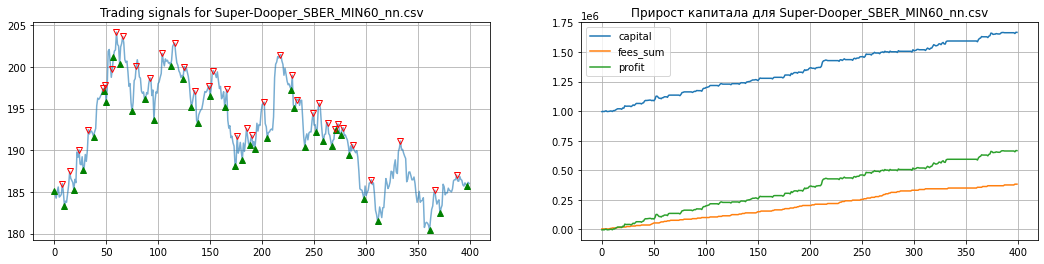


 ------------------------------------------------------------------------------------------ 

_SBER_Dense_1h_v2.h5

Прибыль:	 687371.97 
Доходность:	 0.6941477478002822 
Купи и держи:	 0.00518750675456613


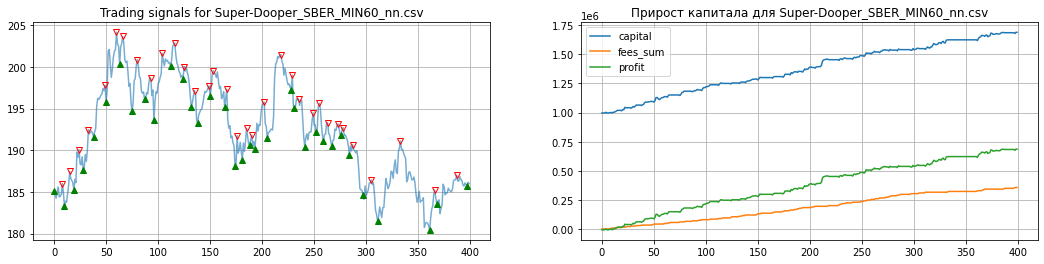


 ------------------------------------------------------------------------------------------ 

_SBER_Dense_1h.h5

Прибыль:	 677486.6499999999 
Доходность:	 0.6842227325031007 
Купи и держи:	 0.00518750675456613


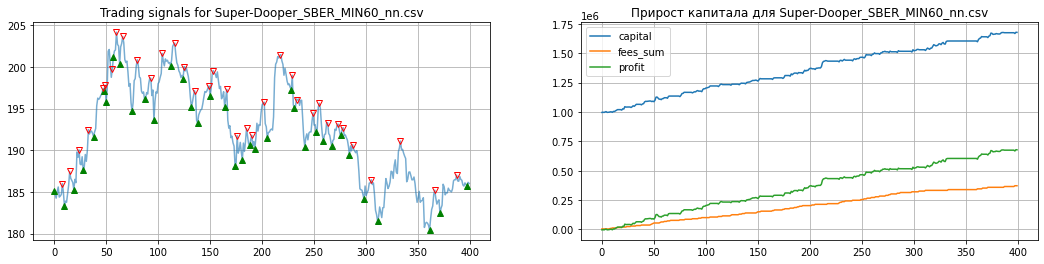


 ------------------------------------------------------------------------------------------ 

_SBER_LSTM_1h_v2.h5

Прибыль:	 703072.03 
Доходность:	 0.7099108526534044 
Купи и держи:	 0.00518750675456613


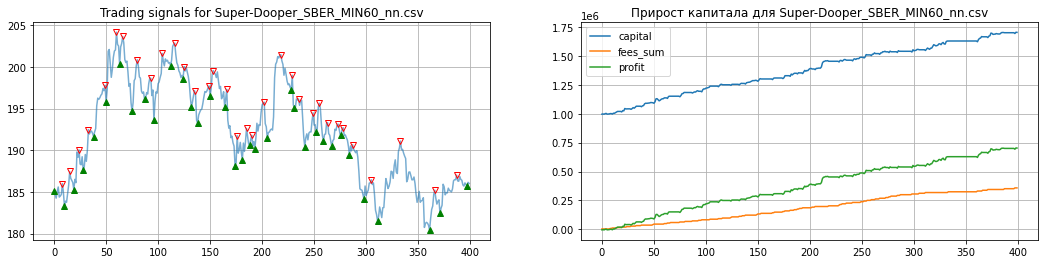


 ------------------------------------------------------------------------------------------ 

_SBER_Conv_2_1h.h5

Прибыль:	 661865.4199999999 
Доходность:	 0.6685387741981811 
Купи и держи:	 0.00518750675456613


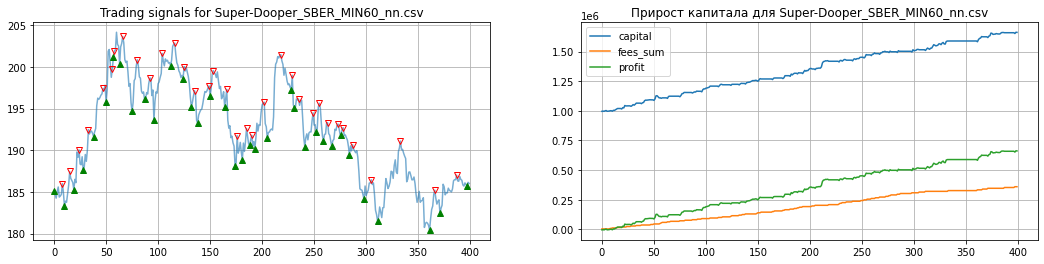


 ------------------------------------------------------------------------------------------ 

_SBER_LSTM_1h.h5

Прибыль:	 703072.03 
Доходность:	 0.7099108526534044 
Купи и держи:	 0.00518750675456613


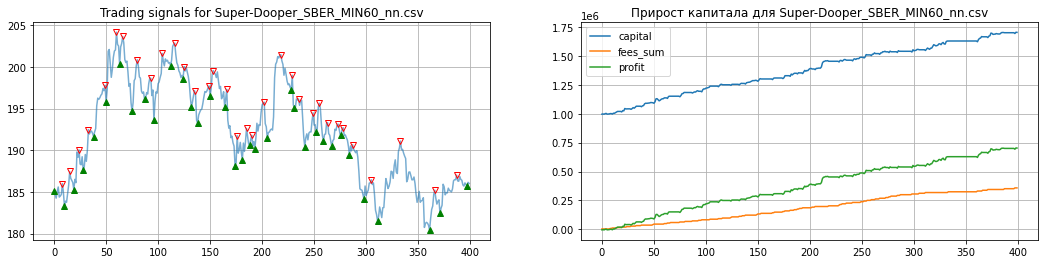


 ------------------------------------------------------------------------------------------ 

_SBER_CONC_1h.h5

Прибыль:	 703072.03 
Доходность:	 0.7099108526534044 
Купи и держи:	 0.00518750675456613


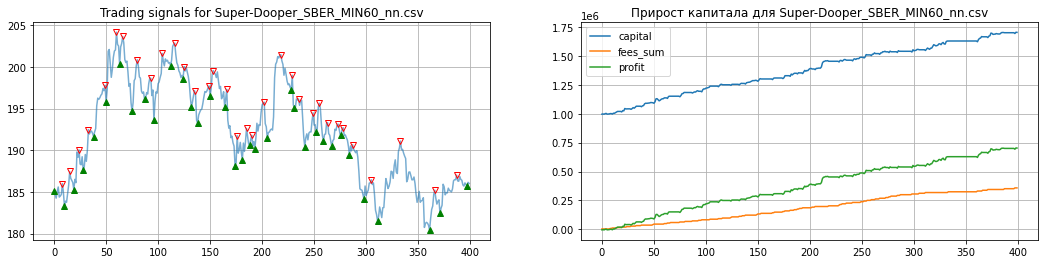


 ------------------------------------------------------------------------------------------ 



In [98]:
# Проверка всех сохраненных моделей Long с учетом комиссии брокера
for model_name in models_list:
  print(model_name)
  os.chdir(path_models)
  model = load_model(model_name)

  os.chdir(path_outputs)
  returns = trading_long(model, xTest, commission = 0.004)

  print('\nПрибыль:\t', float(returns['capital'][-1:] - 1000000),
        '\nДоходность:\t', float((returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0]),
        '\nКупи и держи:\t', float((returns['close'][-1:] - returns['close'][0])/returns['close'][0]),)
  plotting_long(returns) #график торговли

  # запись Журнала торговли в файл
  df_output = returns[['close', 'stock']]
  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output
  df_output = pd.concat([df_date, df_output],axis=1).set_index('datetime')
  df_output['order'] = df_output['stock'].diff()
  df_output['order'][0] = df_output['stock'][0]
  del df_output['stock']

  df_output.to_csv('xTest_long_' + model_name[:-3] + '.txt', sep='\t')
  print('\n', '-'*90, '\n')

# Проверка на 2019 годе

## Подготовка данных

In [99]:
# Период на котором будем ПРОВЕРЯТЬ нейронку
# Надо откусывать на ensemble назад, тк первые тики откусываются при формировании ансамблей
# пока подобрал вручную но потом нужно сделать автоматически
mask2019 = (df['datetime'] >= '2018-12-28 14:00:00') & (df['datetime'] <= '2019-12-31 23:59:00')
data2019 = df[mask2019]
#del data2019['Order'], data2019['Order_NN']
data2019

,datetime,Open,High,Low,Close,Order,Order_NN
40851,2018-12-28 14:00:00,186.47,187.10,186.05,187.01,-1,-1
40852,2018-12-28 15:00:00,187.00,187.22,186.09,186.32,0,-1
40853,2018-12-28 16:00:00,186.36,186.59,185.64,186.28,0,-1
40854,2018-12-28 17:00:00,186.34,187.20,186.12,186.85,0,-1
40855,2018-12-28 18:00:00,186.88,186.97,185.00,186.50,0,-1
...,...,...,...,...,...,...,...
43128,2019-12-30 14:00:00,253.05,255.25,252.97,255.21,0,1
43129,2019-12-30 15:00:00,255.20,256.00,254.86,255.16,0,1
43130,2019-12-30 16:00:00,255.16,255.94,254.53,255.62,-1,-1
43131,2019-12-30 17:00:00,255.62,255.65,254.55,254.81,0,-1


In [100]:
# найдем изменение цены по отношению к прошлой на step_in_the_last шагов назад
"""
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  data2019[indicator_name] = data2019['Close'].pct_change(i) # относительная доходность единицах

data2019 = data2019.dropna() # удаляем строки с NaN

# Добавил разметку как в Y но сдвинул на тренд
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  indicator_name_new = 'Y_%d' % (i)
  data2019[indicator_name_new] = 0
  data2019.loc[data2019[indicator_name] < 0, indicator_name_new] = -1
  data2019.loc[data2019[indicator_name] > 0, indicator_name_new] = 1

print(data2019.shape)
data2019[:3]"""

"\nfor i in range(1, step_in_the_last + 1):\n  indicator_name = 'Close_chng_%d' % (i)\n  data2019[indicator_name] = data2019['Close'].pct_change(i) # относительная доходность единицах\n\ndata2019 = data2019.dropna() # удаляем строки с NaN\n\n# Добавил разметку как в Y но сдвинул на тренд\nfor i in range(1, step_in_the_last + 1):\n  indicator_name = 'Close_chng_%d' % (i)\n  indicator_name_new = 'Y_%d' % (i)\n  data2019[indicator_name_new] = 0\n  data2019.loc[data2019[indicator_name] < 0, indicator_name_new] = -1\n  data2019.loc[data2019[indicator_name] > 0, indicator_name_new] = 1\n\nprint(data2019.shape)\ndata2019[:3]"

In [101]:
# тут я удаляю "не нужные" данные и переимновываю под привычные мне
# и под стандарт, в котором выдает данные сервис yahoo (на всякий случай)
df_date = data2019['datetime'] # Оставляем дату, чтобы потом добавить в outputs
del data2019['datetime']
df_date[:3]

40851    2018-12-28 14:00:00
40852    2018-12-28 15:00:00
40853    2018-12-28 16:00:00
Name: datetime, dtype: object

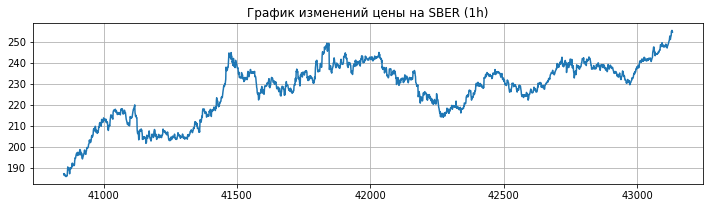

In [102]:
plt.figure(figsize=(12,4))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
data2019['Close'].plot(ax = ax0)
plt.title('График изменений цены на SBER (1h)')
plt.grid()

In [103]:
data2019 = data2019.values
print(data2019.shape, type(data2019))
data2019[-2:]

(2282, 6) <class 'numpy.ndarray'>


array([[255.62, 255.65, 254.55, 254.81,   0.  ,  -1.  ],
       [254.81, 255.2 , 254.6 , 254.75,   1.  ,   1.  ]])

In [104]:
""" 
#  Скалируем Х по обученному на 2015-2018
"""
xScaler.fit(data)
xTest = xScaler.transform(data2019)

print(xTest.shape, type(xTest))
xTest[-1:]

(2282, 6) <class 'numpy.ndarray'>


array([[0.96175228, 0.94814732, 0.97941013, 0.95605431, 1.        ,
        1.        ]])

In [105]:
# проверяю обратную трансформацию
x = xScaler.inverse_transform(xTest[-1:])
x[-1][3]

254.75

In [106]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# trend = число баров в прошлом для анализа - необходимо найти оптимальный!!
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence_Test(sequence, ensemble, forvard_lag=0):
  # sequence = df.values - это массив из данных
  # trend = число баров в прошлом для анализа
  X = list()
  for i in range(len(sequence)):
    end_ix = i + ensemble # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x = sequence[i:end_ix]
    X.append(seq_x)

  return array(X)

In [107]:
"""
# Число баров в прошлом для анализа - место для эксперимента от 0 до 90
"""
# Формируем выборки для обучения нейросети
xTest = split_sequence_Test(xTest, ensemble, forvard_lag=0)

print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
print('Массивы xTrain и yTrain:\t', xTest.shape)


Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTrain и yTrain:	 (2243, 40, 6)


In [108]:
close = xScaler.inverse_transform(xTest[-1])
close[-1][3], yTest[-1] #сдвинули Y на 1 назад и поэтому исчез последний X

(254.75, array([0., 1., 0.], dtype=float32))

In [109]:
close = xScaler.inverse_transform(xTest[-2])
close[-1][3], yTest[-2]

(254.81, array([0., 1., 0.], dtype=float32))

##  Проверка моделей на торговле Lonf-Short

In [110]:
# Проверка всех сохраненных моделей, торговля Long/Short без комиссии брокера
"""
for model_name in models_list:
  print(model_name)
  os.chdir(path_models)
  model = load_model(model_name)

  os.chdir(path_outputs)
  returns = trading(model, xTest)

  print('\nПрибыль:\t', float(returns['capital'][-1:] - 1000000),
        '\nДоходность:\t', float((returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0]),
        '\nКупи и держи:\t', float((returns['close'][-1:] - returns['close'][0])/returns['close'][0]),)
  plotting(returns) #график торговли

  # запись Журнала торговли в файл
  df_output = returns[['close', 'stock']]
  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output
  df_output = pd.concat([df_date, df_output],axis=1).set_index('datetime')
  df_output['order'] = df_output['stock'].diff()
  df_output['order'][0] = df_output['stock'][0]
  del df_output['stock']

  df_output.to_csv('Test2019_' + model_name[:-3] + '.txt', sep='\t')
  print('\n', '-'*90, '\n')
"""

"\nfor model_name in models_list:\n  print(model_name)\n  os.chdir(path_models)\n  model = load_model(model_name)\n\n  os.chdir(path_outputs)\n  returns = trading(model, xTest)\n\n  print('\nПрибыль:\t', float(returns['capital'][-1:] - 1000000),\n        '\nДоходность:\t', float((returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0]),\n        '\nКупи и держи:\t', float((returns['close'][-1:] - returns['close'][0])/returns['close'][0]),)\n  plotting(returns) #график торговли\n\n  # запись Журнала торговли в файл\n  df_output = returns[['close', 'stock']]\n  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output\n  df_output = pd.concat([df_date, df_output],axis=1).set_index('datetime')\n  df_output['order'] = df_output['stock'].diff()\n  df_output['order'][0] = df_output['stock'][0]\n  del df_output['stock']\n\n  df_output.to_csv('Test2019_' + model_name[:-3] + '.txt', sep='\t')\n  print('\n'

## Проверка модели на торговле в long

### Моделирование торговли

In [111]:
# Проверка всех сохраненных моделей без комиссии, торговля Long
"""
for model_name in models_list:
  print(model_name)
  os.chdir(path_models)
  model = load_model(model_name)

  os.chdir(path_outputs)
  returns = trading_long(model, xTest, commission = 0)

  print('\nПрибыль:\t', float(returns['capital'][-1:] - 1000000),
        '\nДоходность:\t', float((returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0]),
        '\nКупи и держи:\t', float((returns['close'][-1:] - returns['close'][0])/returns['close'][0]),)
  plotting_long(returns) #график торговли

  # запись Журнала торговли в файл
  df_output = returns[['close', 'stock']]
  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output
  df_output = pd.concat([df_date, df_output],axis=1).set_index('datetime')
  df_output['order'] = df_output['stock'].diff()
  df_output['order'][0] = df_output['stock'][0]
  del df_output['stock']

  df_output.to_csv('Test2019_' + model_name[:-3] + '.txt', sep='\t')
  print('\n', '-'*90, '\n')
  """

"\nfor model_name in models_list:\n  print(model_name)\n  os.chdir(path_models)\n  model = load_model(model_name)\n\n  os.chdir(path_outputs)\n  returns = trading_long(model, xTest, commission = 0)\n\n  print('\nПрибыль:\t', float(returns['capital'][-1:] - 1000000),\n        '\nДоходность:\t', float((returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0]),\n        '\nКупи и держи:\t', float((returns['close'][-1:] - returns['close'][0])/returns['close'][0]),)\n  plotting_long(returns) #график торговли\n\n  # запись Журнала торговли в файл\n  df_output = returns[['close', 'stock']]\n  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output\n  df_output = pd.concat([df_date, df_output],axis=1).set_index('datetime')\n  df_output['order'] = df_output['stock'].diff()\n  df_output['order'][0] = df_output['stock'][0]\n  del df_output['stock']\n\n  df_output.to_csv('Test2019_' + model_name[:-3] + '.txt

_SBER_Conv_1h.h5

Прибыль:	 4298342.81 
Доходность:	 4.319620280393721 
Купи и держи:	 0.33418875039279355


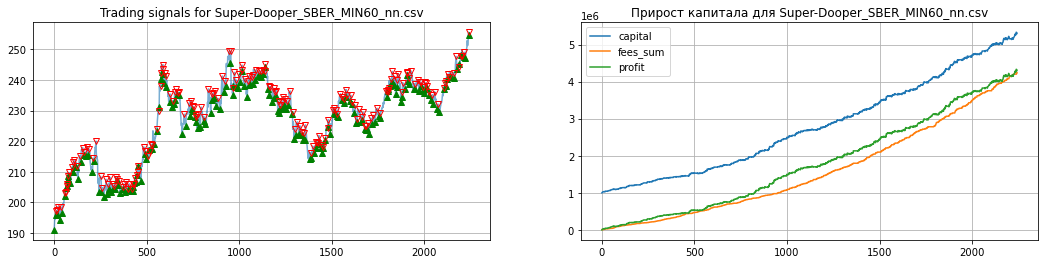


 ------------------------------------------------------------------------------------------ 

_SBER_Dense_1h_v2.h5

Прибыль:	 952876.03 
Доходность:	 0.9607185315898384 
Купи и держи:	 0.33418875039279355


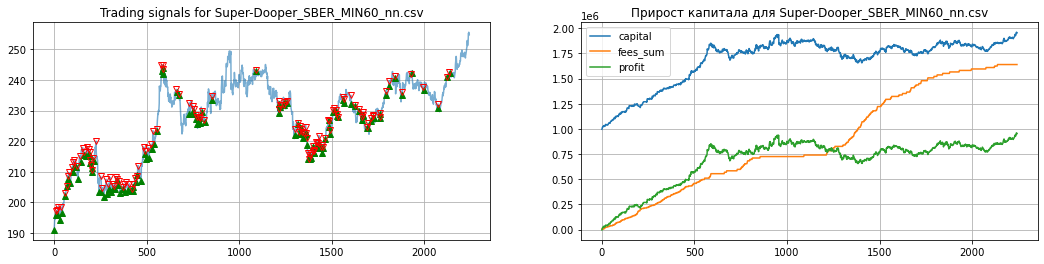


 ------------------------------------------------------------------------------------------ 

_SBER_Dense_1h.h5

Прибыль:	 2761693.87 
Доходность:	 2.776800353823226 
Купи и держи:	 0.33418875039279355


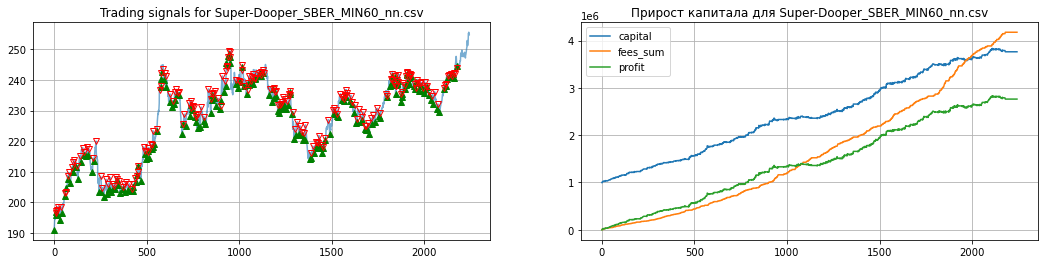


 ------------------------------------------------------------------------------------------ 

_SBER_LSTM_1h_v2.h5

Прибыль:	 5733942.33 
Доходность:	 5.760984985354271 
Купи и держи:	 0.33418875039279355


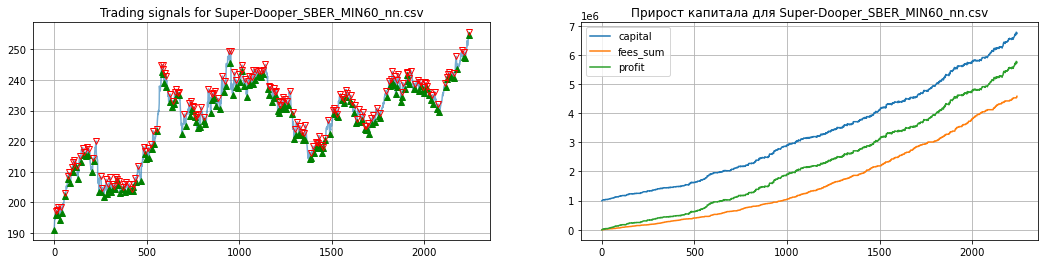


 ------------------------------------------------------------------------------------------ 

_SBER_Conv_2_1h.h5

Прибыль:	 4175064.62 
Доходность:	 4.195847020872557 
Купи и держи:	 0.33418875039279355


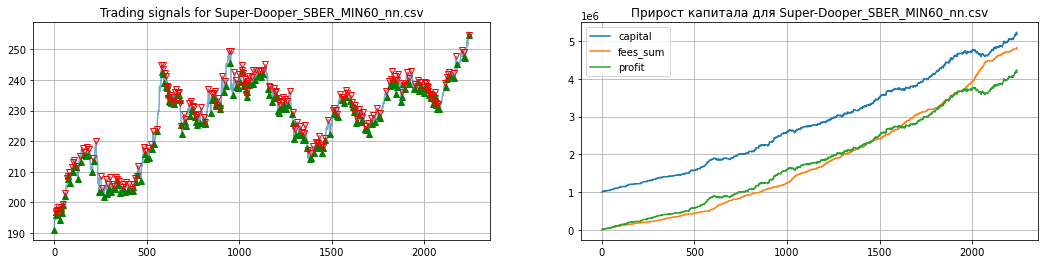


 ------------------------------------------------------------------------------------------ 

_SBER_LSTM_1h.h5

Прибыль:	 5733942.33 
Доходность:	 5.760984985354271 
Купи и держи:	 0.33418875039279355


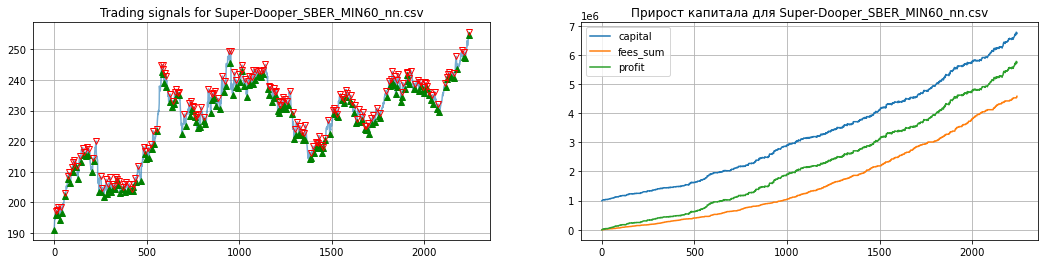


 ------------------------------------------------------------------------------------------ 

_SBER_CONC_1h.h5

Прибыль:	 5666772.01 
Доходность:	 5.693544917898058 
Купи и держи:	 0.33418875039279355


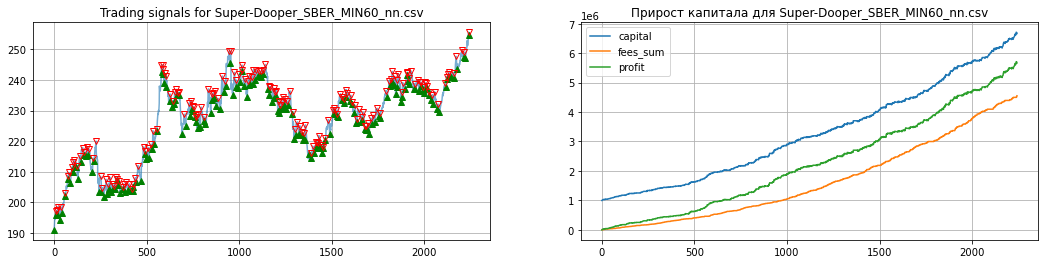


 ------------------------------------------------------------------------------------------ 



In [112]:
# Проверка всех сохраненных моделей c commission = 0.004, торговля Long
for model_name in models_list:
  print(model_name)
  os.chdir(path_models)
  model = load_model(model_name)

  os.chdir(path_outputs)
  returns = trading_long(model, xTest, commission = 0.004)

  print('\nПрибыль:\t', float(returns['capital'][-1:] - 1000000),
        '\nДоходность:\t', float((returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0]),
        '\nКупи и держи:\t', float((returns['close'][-1:] - returns['close'][0])/returns['close'][0]),)
  plotting_long(returns) #график торговли

  # запись Журнала торговли в файл
  df_output = returns[['close', 'stock']]
  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output
  df_output = pd.concat([df_date, df_output],axis=1).set_index('datetime')
  df_output['order'] = df_output['stock'].diff()
  df_output['order'][0] = df_output['stock'][0]
  del df_output['stock']

  df_output.to_csv('Test2019_comission_' + model_name[:-3] + '.txt', sep='\t')
  print('\n', '-'*90, '\n')

# Вывод:
-----
1. НС таки ленится и часто просто повторяет предыдущий сигнал разметки
2. Ансамбль нейронных сетей позволяет достичь стабильный хороший результат даже когда 1 или 2 из отдельных НС лажают
3. Дальше нужно работать над Features engineering для того, чтобы уйти от повторения предыдущего сигнала и повысить точность